In [59]:
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpimg
import numpy as np
import os
from skimage import exposure
from pybalu.feature_extraction import lbp_features, haralick_features, hog_features
import pickle
from pybalu.feature_transformation import normalize, pca
from sklearn.metrics import accuracy_score

# Load images

Formato:

```
[
    [img_1_A, img_1_B],
    ...
]
```

In [ ]:
def load_images(data_dir, data_size):
    img_names = sorted(os.listdir(data_dir))
    data = []
    sizes = defaultdict(int)
    for i in range(0, len(img_names), 2):
        tmp_data = []
        for j in range(2):
            img_path = os.path.join(data_dir, img_names[i + j])
            img = cv2.imread(img_path, 0)
            sizes[img.shape] += 1
            if img.shape != data_size:
                img = cv2.resize(img, data_size[:-1])
            tmp_data.append(img)
        data.append(tmp_data)
    print(sizes)
    return np.array(data)

In [ ]:
TRAINING_DIR = '/home/chrisams/Datasets/patrones_project/training'
TESTING_DIR = '/home/chrisams/Datasets/patrones_project/testing'

In [ ]:
X_train = load_images(TRAINING_DIR, (256, 256, 3))
X_test = load_images(TESTING_DIR, (256, 256, 3))

In [ ]:
X_train.shape, X_test.shape

# Testing loaded images

In [ ]:
n = 0
test_a = X_train[n][0]
test_b = X_train[n][1]

# Denoise
test_a_denoise = cv2.fastNlMeansDenoising(test_a,None, 10, 10, 17)

# Equalization
test_a_eq = exposure.equalize_hist(test_a_denoise)
test_b_eq = exposure.equalize_hist(test_b)

plt.figure(figsize=(10,10))
plt.subplot(321),plt.imshow(test_a)
plt.subplot(322),plt.imshow(test_b)
plt.subplot(323),plt.imshow(test_a_eq)
plt.subplot(324),plt.imshow(test_b_eq)
plt.subplot(325),plt.imshow(test_a)
plt.subplot(326),plt.imshow(test_a_denoise)
plt.show()

In [ ]:
n = 5
test_a = X_test[n][0]
test_b = X_test[n][1]

#asda
test_a_denoise = cv2.fastNlMeansDenoising(test_a,None, 10, 10, 17)

# Equalization
test_a_eq = exposure.equalize_hist(test_a_denoise)
test_b_eq = exposure.equalize_hist(test_b)

plt.figure(figsize=(10,10))
plt.subplot(321),plt.imshow(test_a)
plt.subplot(322),plt.imshow(test_b)
plt.subplot(323),plt.imshow(test_a_eq)
plt.subplot(324),plt.imshow(test_b_eq)
plt.subplot(325),plt.imshow(test_a)
plt.subplot(326),plt.imshow(test_a_denoise)
plt.show()

# Data preprocessing

In [ ]:
def preprocess_data(X, preprocess):
    new_data = []
    for i in range(X.shape[0]):
        img_a = X[i][0]
        img_b = X[i][1]
        for func in preprocess:
            img_a, img_b = func(img_a, img_b)
        new_data.append([img_a, img_b])
    return np.array(new_data)

In [ ]:
preprocess = [
    lambda x, y: (cv2.fastNlMeansDenoising(x, None, 10, 10, 17), y),
    lambda x, y: (exposure.equalize_hist(x), exposure.equalize_hist(y)),
]

SAVE_DIR_TRAIN = '/home/chrisams/Datasets/patrones_project/training_preprocessed'
SAVE_DIR_TEST = '/home/chrisams/Datasets/patrones_project/test_preprocessed'

In [ ]:
#X_train = preprocess_data(X_train, preprocess)
X_test = preprocess_data(X_test, preprocess)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(X_test[1][0])
plt.subplot(122),plt.imshow(X_test[1][1])
plt.show()

# Save preprocessed data

Así no se tiene que hacer todo el procedimiento de preprocesamiento a cada rato.

In [ ]:
# with open('X_train_preprocessed.npy', 'wb') as f:
#     np.save(f, X_train)

In [ ]:
# with open('X_test_preprocessed.npy', 'wb') as f:
#     np.save(f, X_test)

# Experiments with training data

In [2]:
with open('/home/chrisams/Datasets/patrones_project/X_train_preprocessed.npy', 'rb') as f:
    X = np.load(f)

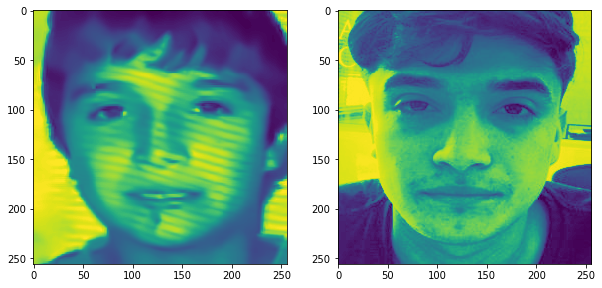

In [3]:
# Check loaded images.
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(X[5][0])
plt.subplot(122),plt.imshow(X[5][1])
plt.show()

In [4]:
def get_features(X, funcs):
    data = []
    for i in range(X.shape[0]):
        img_a_feats = []
        img_b_feats = []
        for func in funcs:
            img_a_feats.append(func(X[i][0]))
            img_b_feats.append(func(X[i][1]))
        data.append([np.concatenate(img_a_feats), np.concatenate(img_b_feats)])
    return np.array(data)

def get_negative_examples(X, n):
    """n is the number of negative examples per image.
    """
    data = []
    N = len(X)
    choice_idxs = list(range(N))
    for i, (img_a, img_b) in enumerate(X):
        tmp_choice_idxs = choice_idxs.copy()
        tmp_choice_idxs.remove(i)
        negatives_idx = np.random.choice(tmp_choice_idxs, size=n, replace=False)
        for negative_idx in negatives_idx:
            negative_old = X[negative_idx][1]
            data.append([img_a, negative_old])
    return np.array(data)

In [5]:
# Features to extract.
funcs = [
    lambda x: lbp_features(x, hdiv=3, vdiv=3, mapping='nri_uniform'),
    lambda x: haralick_features(x),
    lambda x: hog_features(x, v_windows=3, h_windows=3, n_bins=8),
]

# Train: Ejemplos positivos

In [6]:
X_feats = get_features(X, funcs)

In [8]:
X_feats.shape

(1750, 2, 631)

In [9]:
X_feats_y = X_feats[:, 0, :]
X_feats_o = X_feats[:, 1, :]
X_feats_y.shape, X_feats_o.shape

((1750, 631), (1750, 631))

In [10]:
X_feats_y_pca, _, A_y, Xm_y, _ = pca(X_feats_y, n_components=20)
X_feats_o_pca, _, A_o, Xm_o, _ = pca(X_feats_o, n_components=20)
X_feats_y_pca.shape, X_feats_o_pca.shape

((1750, 20), (1750, 20))

In [11]:
X_feats_y_norm, a_y, b_y = normalize(X_feats_y_pca)
X_feats_o_norm, a_o, b_o = normalize(X_feats_o_pca)

In [12]:
shapey = X_feats_y_norm.shape
shapeo = X_feats_o_norm.shape
X_pos = np.concatenate([X_feats_y_norm.reshape(shapey[0], 1, shapey[1]),
                        X_feats_o_norm.reshape(shapeo[0], 1, shapeo[1])], axis=1)

In [13]:
X_pos.shape

(1750, 2, 20)

# Train: Ejemplos negativos

In [14]:
X_feats_neg = get_negative_examples(X_feats, 1)

In [15]:
X_feats_neg_y = X_feats_neg[:, 0, :]
X_feats_neg_o = X_feats_neg[:, 1, :]
X_feats_neg_y.shape, X_feats_neg_o.shape

((1750, 631), (1750, 631))

In [16]:
X_feats_neg_y_pca = np.matmul(X_feats_neg_y - Xm_y, A_y)
X_feats_neg_o_pca = np.matmul(X_feats_neg_o - Xm_o, A_o)

In [17]:
X_feats_neg_y_norm = X_feats_neg_y_pca * a_y + b_y
X_feats_neg_o_norm = X_feats_neg_o_pca * a_o + b_o

In [18]:
shapey = X_feats_y_norm.shape
shapeo = X_feats_o_norm.shape
X_neg = np.concatenate([X_feats_neg_y_norm.reshape(shapey[0], 1, shapey[1]),
                        X_feats_neg_o_norm.reshape(shapeo[0], 1, shapeo[1])], axis=1)

In [19]:
X_neg.shape

(1750, 2, 20)

# Train: Merge

In [20]:
X_merge = np.concatenate([X_pos, X_neg], axis=0)
X_merge = np.reshape(X_merge, (X_merge.shape[0], -1))
X_merge.shape

(3500, 40)

# Train: Labels

In [21]:
y_pos = np.ones(X_pos.shape[0])
y_neg = np.zeros(X_neg.shape[0])
y = np.concatenate([y_pos, y_neg])
y, y.shape

(array([1., 1., 1., ..., 0., 0., 0.]), (3500,))

## Experimentos con MLP

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_merge, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    shuffle=True)
clf = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), learning_rate='adaptive')
clf.fit(X_train_b, y_train_b)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [46]:
y_pred_val = clf.predict(X_test_b)

In [47]:
print(classification_report(y_test_b, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.56      0.57      0.56       438
         1.0       0.56      0.56      0.56       437

    accuracy                           0.56       875
   macro avg       0.56      0.56      0.56       875
weighted avg       0.56      0.56      0.56       875



In [48]:
clf.score(X_test_b, y_test_b)

0.5634285714285714

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_merge, y,
                                                    stratify=y, 
                                                    test_size=0.25,
                                                    shuffle=True)
clf = SVC(gamma='auto')
clf.fit(X_train_b, y_train_b)
y_pred_val = clf.predict(X_test_b)
print(classification_report(y_test_b, y_pred_val))
print(clf.score(X_test_b, y_test_b))

              precision    recall  f1-score   support

         0.0       0.55      0.54      0.54       438
         1.0       0.54      0.55      0.55       437

    accuracy                           0.55       875
   macro avg       0.55      0.55      0.55       875
weighted avg       0.55      0.55      0.55       875

0.5451428571428572


# Test

In [27]:
with open('/home/chrisams/Datasets/patrones_project/X_test_preprocessed.npy', 'rb') as f:
    Xt = np.load(f)

# Test: Ejemplos positivos

In [28]:
Xt_f = get_features(Xt, funcs)

In [29]:
Xt_f.shape

(472, 2, 631)

In [30]:
Xt_fy = Xt_f[:, 0, :]
Xt_fo = Xt_f[:, 1, :]
Xt_fy.shape, Xt_fo.shape

((472, 631), (472, 631))

In [31]:
Xt_fy_pca = np.matmul(Xt_fy - Xm_y, A_y)
Xt_fo_pca = np.matmul(Xt_fo - Xm_o, A_o)
Xt_fy_pca.shape, Xt_fo_pca.shape

((472, 20), (472, 20))

In [32]:
Xt_fy_norm = Xt_fy_pca * a_y + b_y
Xt_fo_norm = Xt_fo_pca * a_o + b_o

In [33]:
shapey = Xt_fy_norm.shape
shapeo = Xt_fo_norm.shape
Xt_pos = np.concatenate([Xt_fy_norm.reshape(shapey[0], 1, shapey[1]),
                        Xt_fo_norm.reshape(shapeo[0], 1, shapeo[1])], axis=1)

In [34]:
Xt_pos.shape

(472, 2, 20)

# Test: ejemplos negativos

In [35]:
Xt_f_neg = get_negative_examples(Xt_f, 1)

In [37]:
Xt_fy_neg = Xt_f_neg[:, 0, :]
Xt_fo_neg = Xt_f_neg[:, 1, :]
Xt_fy_neg.shape, Xt_fo_neg.shape

((472, 631), (472, 631))

In [38]:
Xt_fy_neg_pca = np.matmul(Xt_fy_neg - Xm_y, A_y)
Xt_fo_neg_pca = np.matmul(Xt_fo_neg - Xm_o, A_o)

In [39]:
Xt_fy_neg_norm = Xt_fy_neg_pca * a_y + b_y
Xt_fo_neg_norm = Xt_fo_neg_pca * a_o + b_o

In [40]:
shapey = Xt_fy_neg_norm.shape
shapeo = Xt_fo_neg_norm.shape
Xt_neg = np.concatenate([Xt_fy_neg_norm.reshape(shapey[0], 1, shapey[1]),
                         Xt_fo_neg_norm.reshape(shapeo[0], 1, shapeo[1])], axis=1)

In [41]:
Xt_neg.shape

(472, 2, 20)

# Test: Merge

In [42]:
Xt_merge = np.concatenate([Xt_pos, Xt_neg], axis=0)
Xt_merge = np.reshape(Xt_merge, (Xt_merge.shape[0], -1))
Xt_merge.shape

(944, 40)

# Test: Labels

In [44]:
yt_pos = np.ones(Xt_pos.shape[0])
yt_neg = np.zeros(Xt_neg.shape[0])
yt = np.concatenate([yt_pos, yt_neg])
yt.shape

(944,)

In [58]:
y_pred_test = clf.predict(Xt_merge)

In [60]:
accuracy_score(yt, y_pred_test)

0.600635593220339

In [51]:
def get_matrix(X_new, X_old, estimator):
    matrix = np.zeros((X_new.shape[0], X_old.shape[0]))
    for i in range(X_new.shape[0]):
        for j in range(X_old.shape[0]):
            matrix[i][j] = estimator.predict_proba(np.concatenate([X_new[i], X_old[j]]).reshape(1, -1))[0][1]
    return matrix

In [52]:
S = get_matrix(Xt_fy_norm, Xt_fo_norm, clf)

In [53]:
S.shape

(472, 472)

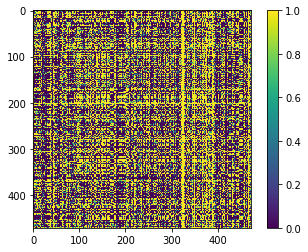

In [54]:
plt.imshow(S)
plt.colorbar()
plt.show()

In [55]:
diagonal = S.diagonal()
non_diagonal = S[np.where(~np.eye(S.shape[0],dtype=bool))]

diagonal.shape, non_diagonal.shape

((472,), (222312,))

In [56]:
import math

mu_1, sigma_1 = np.mean(diagonal), np.std(diagonal)
mu_2, sigma_2 = np.mean(non_diagonal), np.std(non_diagonal)

d = math.fabs(mu_2 - mu_1) / math.sqrt((sigma_1**2 + sigma_2**2) / 2)
d

0.44659410980995895

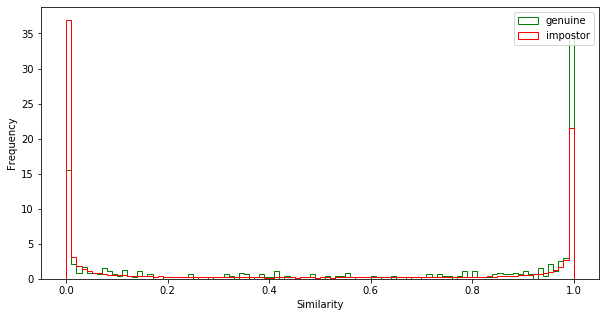

In [57]:
plt.figure(figsize=(10,5))
plt.hist(diagonal, 100, label='genuine', histtype='step', density=True, color='green', stacked=True)
plt.hist(non_diagonal, 100, label='impostor', histtype='step', density=True, color='red', stacked=True)
plt.legend()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.savefig('feats_ignacio.jpeg', dpi=300, pad_inches=0.1, bbox_inches='tight')
plt.show()